In [ ]:
%matplotlib inline

import sys
!git clone https://www.github.com/hrmacbeth/turtle-dynamical.git
sys.path.append('turtle-dynamical')

!pip install --upgrade scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import config as cfg

cfg.optimizer_file = 'jason_bonner_jupyter_notebook'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles
from datasets import make_linearly_separable
from neural_network import MLPClassifier
from draw_script import *

fatal: destination path 'turtle-dynamical' already exists and is not an empty directory.


The goal of this notebook is to give an understanding of how neural networks are trained and make predictions.

# The data

First we introduce the datasets we will use.  For pedagogical purposes, these are "synthetic" datasets, which means that they don't come from real-world data.  Instead we generate each one semi-randomly, based off a probability distribution which we know but our future neural network does not -- it will have to "learn" it.

These datasets each have 100 data-points.  This is very small by the standards of modern machine learning -- for example, [ImageNet](https://en.wikipedia.org/wiki/ImageNet), a standard dataset of images, contains 14 million images!

1


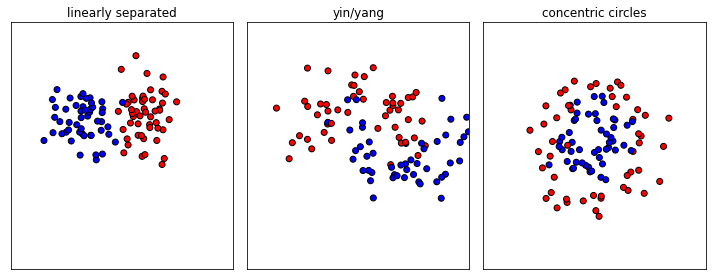

In [ ]:
# Introduce the datasets

datasets = [make_linearly_separable(noise=1, scale=0.6, random_state_1=1, random_state_2=0),
            make_moons(noise=0.3, random_state=2),
            make_circles(noise=0.2, factor=0.5, random_state=3),
            ]
dataset_names = ["linearly separated", "yin/yang", "concentric circles"]
num_datasets = 3

# Let's plot them!

axis_scale = 2.2
figure = plt.figure(figsize=(10, 4))

# iterate over datasets
for a in range(num_datasets):
    ax = plt.subplot(1, num_datasets, a + 1)
    X, y = datasets[a]
    plot_points(ax, axis_scale, X, y)
    ax.set_title(dataset_names[a])

plt.tight_layout()
plt.show()

When we have a machine learning problem like this, we start by separating the data into "training" and "test" portions.  We will build our neural network only using the "training" portion of the data, so the "test" portion can be used as an independent check on the quality of the model.

Here we use a validation split of 0.2; that is, 80% of the data for training and 20% for test.

We divide the data into training and test sets, and then plot it again, using solid dots for the training set and semi-transparent dots for the test set.

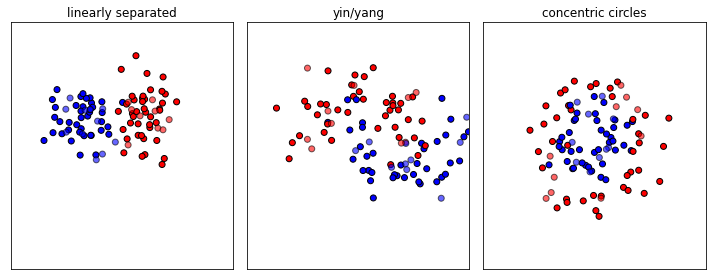

In [ ]:
validation_split = 0.2

X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# split into training and test data, iterating over datasets
for a in range(num_datasets):
    X, y = datasets[a]
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=validation_split, random_state=42)

    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)


# let's plot them again, this time indicating which are training and which test!

figure = plt.figure(figsize=(10, 4))

# iterate over datasets
for a in range(num_datasets):
    ax = plt.subplot(1, len(datasets), a + 1)
    plot_points(ax, axis_scale, X_train_list[a], y_train_list[a], X_test_list[a], y_test_list[a])
    ax.set_title(dataset_names[a])

plt.tight_layout()
plt.show()

# The models

For each of these 3 datasets, we will try 4 different kinds of neural network, to see how they do on modelling the data.

Here we specify the "architecture" of the 4 neural networks; that is, how many neurons there are in each hidden layer.

I have decided to experiment by trying neural networks of varying depth:  one with 0 hidden layers (this is not really a neural network!), one with 1 hidden layer, one with 2 and one with 3.  It's hard to describe rules for the number of neurons per layer -- best just to experiment.

We calculate the number of parameters needed for each of these neural networks.  I've chosen the hidden layer sizes so that each of the nontrivial neural networks has ~85 parameters.  Again, this is very small by the standards of modern AI.  For example, Google's [EfficientNet-B7](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html) has 66 million parameters!

In [ ]:
names = ["Neural Net (0 layers)", "Neural Net (1 layer)", "Neural Net (2 layers)", "Neural Net (3 layers)"]
num_models = len(names)

neural_network_architectures = [(), (22,), (8, 6,), (5, 6, 4)]

neural_networks_list = []

for a in range(num_datasets):
    neural_networks = []
    # iterate over neural network architectures
    for arch in neural_network_architectures:
        neural_networks.append(MLPClassifier(hidden_layer_sizes=arch, alpha = 0.5, random_state=7))
    neural_networks_list.append(neural_networks)

# How many parameters are there on each of these neural networks?
for name, nn in zip(names, neural_networks_list[0]):
    print(f"{name} has {str(nn.num_parameters(2))} parameters")

Neural Net (0 layers) has 3 parameters
Neural Net (1 layer) has 89 parameters
Neural Net (2 layers) has 85 parameters
Neural Net (3 layers) has 84 parameters


# Training the neural networks

Next, we train each of the neural network architectures on each of the datasets, and record their predictions on a wide range of data.

The training process is an optimization algorithm.  You will see that here we perform 1000 iterations.

In [ ]:
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(-axis_scale, axis_scale, h),   # the mesh
                      np.arange(-axis_scale, axis_scale, h))


scores = []
probs = []
coefs = []
intercepts = []

# iterate over datasets
for a in range(num_datasets):

    X_train = X_train_list[a]
    y_train = y_train_list[a]
    X_test = X_test_list[a]
    y_test = y_test_list[a]

    # preprocess the training data by rescaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    # rescale the test data by the same amount
    X_test = scaler.transform(X_test)

    dataset_scores = []
    dataset_probs = []
    dataset_coefs = []
    dataset_intercepts = []

    print()
    
    # iterate over neural networks
    for name, clf in zip(names, neural_networks_list[a]):
        # run the optimization algorithm to fit the given neural network architecture to the given data
        # you might like to try varying some of the optimization parameters
        clf.fit(X_train, y_train, max_iter = 1000)
        dataset_scores.append(clf.score(X_test, y_test))
        dataset_coefs.append(clf.coefs_)
        dataset_intercepts.append(clf.intercepts_)

        # store the probability that the neural network predicts for each point in the plane
        Z = clf.predict_proba(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))[:, 1]
        Z = Z.reshape(xx.shape)
        dataset_probs.append(Z)

    scores.append(dataset_scores)
    probs.append(dataset_probs)
    coefs.append(dataset_coefs)
    intercepts.append(dataset_intercepts)

# Visualizing the neural networks

Finally we visualize the predictions given by each of the neural networks we have trained.  The plots show training points in solid colors and testing points semi-transparent. The lower right shows the classification accuracy on the test set.

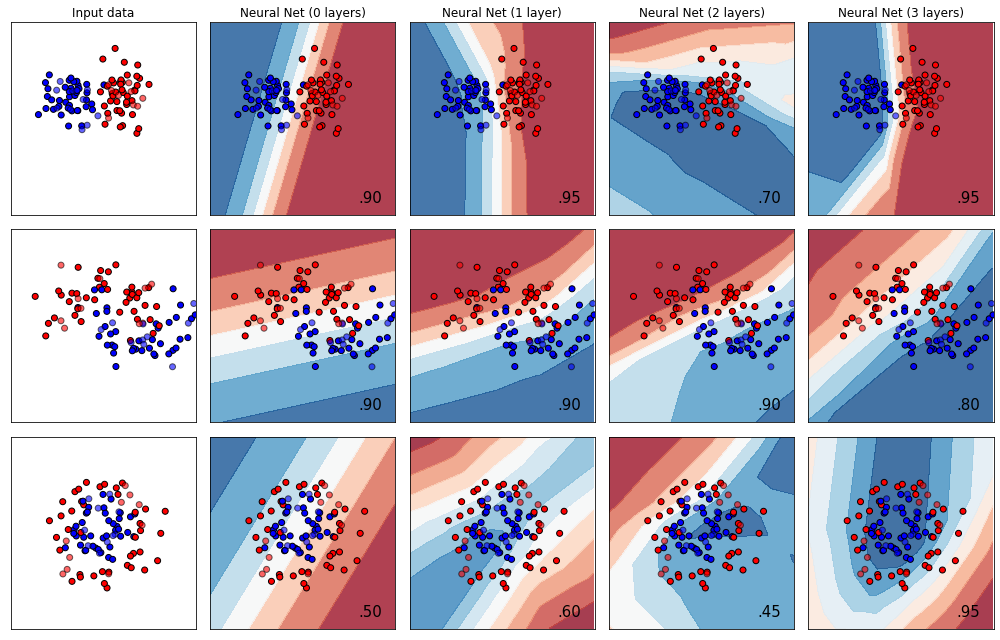

In [ ]:
num_datasets = len(datasets)
num_models = len(names)

figure = plt.figure(figsize=(14, 9))

i = 1
# iterate over datasets
for a in range(num_datasets):

    ax = plt.subplot(num_datasets, num_models + 1, i)

    # just plot the dataset first
    if a == 0:
        ax.set_title("Input data")
    plot_points(ax, axis_scale, X_train_list[a], y_train_list[a], 
                X_test_list[a], y_test_list[a])

    i += 1

    # iterate over classifiers
    for b in range(num_models):
        ax = plt.subplot(num_datasets, num_models + 1, i)

        if a == 0:
            ax.set_title(names[b])

        # plot the background, with colour varying according to probability
        ax.contourf(xx, yy, probs[a][b], cmap=plt.cm.RdBu, alpha=.8)
        # plot the points
        plot_points(ax, axis_scale, X_train_list[a], y_train_list[a], 
                    X_test_list[a], y_test_list[a])

        # add text showing the scores
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % scores[a][b]).lstrip('0'),
                size=15, horizontalalignment='right')
        
        i += 1

plt.tight_layout()
plt.show()